In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
data = pd.read_csv('uber.csv')

In [3]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
data.shape

(200000, 9)

In [5]:
# Drop irrelevant columns
data = data.drop(columns=["Unnamed: 0", "key"])

In [6]:
data.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
# Drop rows with missing values
data = data.dropna()

In [8]:
data.duplicated().sum()

0

In [9]:
data.shape

(199999, 7)

In [10]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


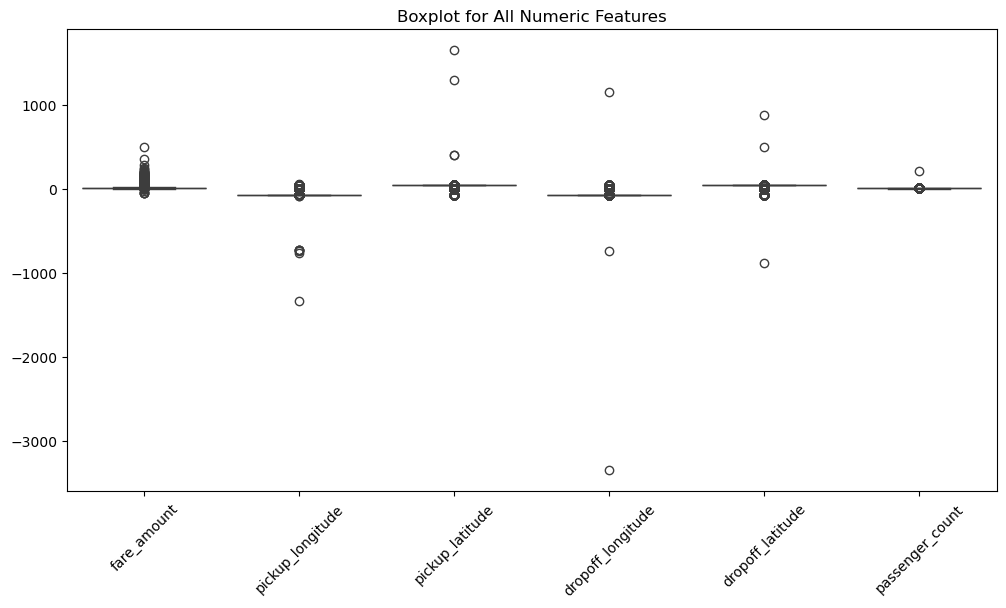

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

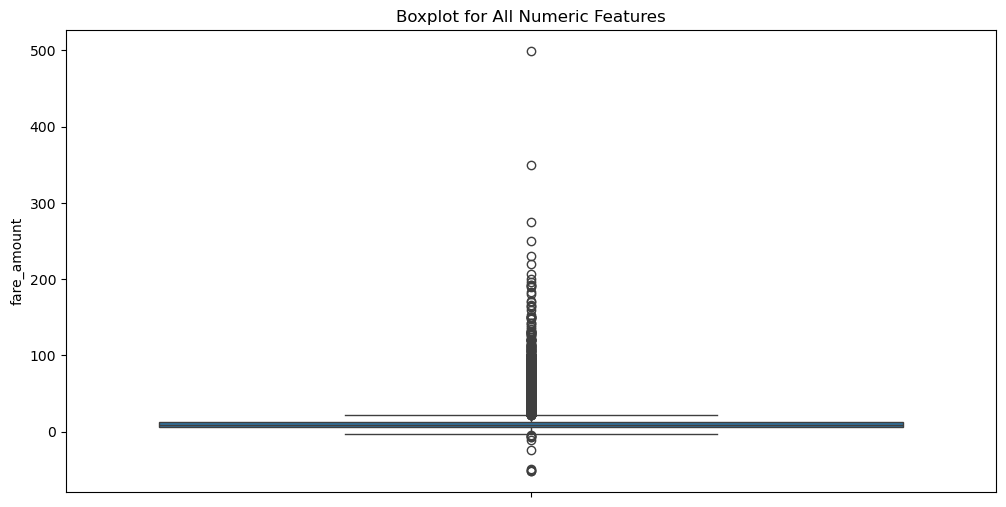

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data['fare_amount'])
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

In [13]:
def remove_outliers(data):
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Keep only rows within the bounds
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

# Apply the function
df_clean = remove_outliers(data)

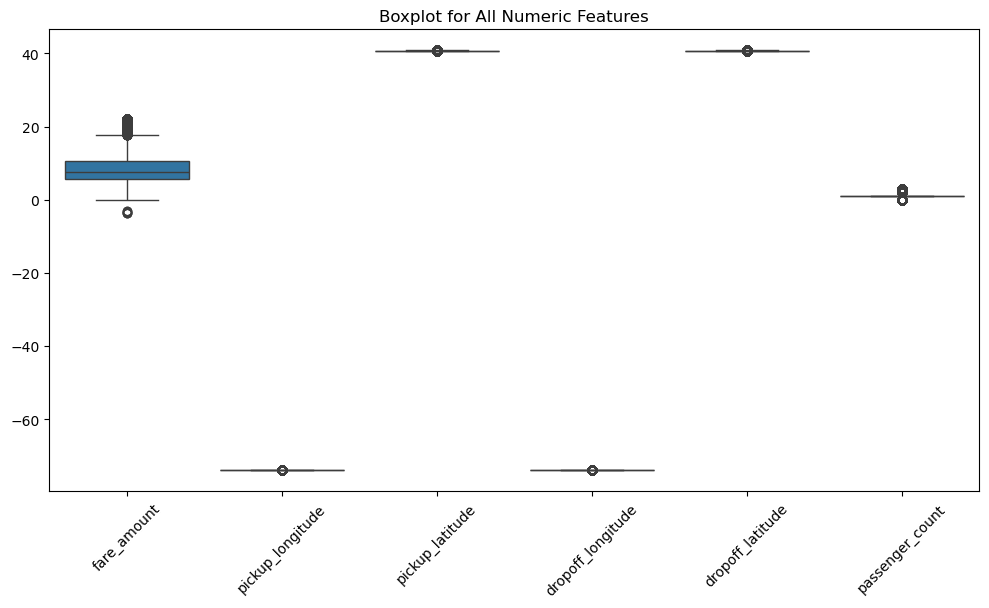

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

In [15]:
data.shape

(199999, 7)

In [16]:
df_clean.shape

(148074, 7)

In [17]:
# Convert datetime
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], errors="coerce")
data["hour"] = data["pickup_datetime"].dt.hour
data["day"] = data["pickup_datetime"].dt.day
data["month"] = data["pickup_datetime"].dt.month
data["weekday"] = data["pickup_datetime"].dt.weekday
data = data.drop(columns=["pickup_datetime"])

In [18]:
# Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    #differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    #Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    #The Haversine formula calculates the great-circle distance between two points on the Earth given their latitude and longitude.

    # This is the shortest distance over the Earth’s surface (as the Earth is roughly spherical).

    # Distance is returned in kilometers because we multiply by 6371 (Earth radius in km)
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

In [19]:
data["distance_km"] = haversine(
    data["pickup_latitude"], data["pickup_longitude"],
    data["dropoff_latitude"], data["dropoff_longitude"]
)

In [32]:
# Remove unrealistic values
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 200)]
data = data[(data["distance_km"] > 0) & (data["distance_km"] < 100)]
data = data[(data["passenger_count"] > 0) & (data["passenger_count"] < 7)]

In [33]:
data.shape

(193188, 11)

In [34]:
X = data[["distance_km", "passenger_count", "hour", "day", "month", "weekday"]]
y = data["fare_amount"]

In [35]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,distance_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,3,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,4,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,0,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,4,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,3,4.475450


In [36]:
data.tail()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,distance_km
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10,6,0.112210
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3,4,1.875050
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6,0,12.850319
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5,2,3.539715
199999,14.1,-73.984395,40.720077,-73.985508,40.768793,1,4,15,5,5,5.417783


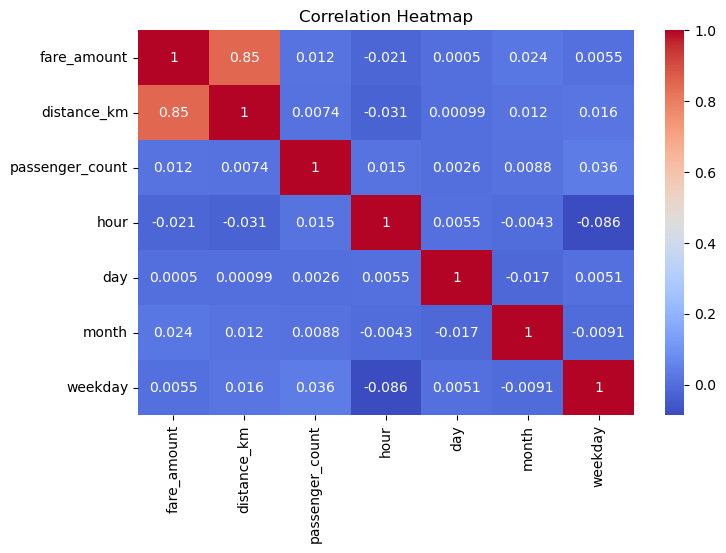

In [37]:
# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(data[["fare_amount","distance_km","passenger_count","hour","day","month","weekday"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

In [41]:
print("\n--- Linear Regression ---")
print("R2 Score:", r2_score(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))


--- Linear Regression ---
R2 Score: 0.7251567240961213
RMSE: 5.023900658752837


## Ridge Regression(L2):
 Adds a penalty equal to the square of the magnitude of coefficients. This helps prevent overfitting by shrinking all coefficients toward zero, stabilizing the model.

In [42]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

print("\n--- Ridge Regression ---")
print("R2 Score:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))


--- Ridge Regression ---
R2 Score: 0.7251566597644097
RMSE: 5.023901246717212


## Lasso Regression(L1):
Adds a penalty equal to the absolute value of the coefficients. This is used for both regularization and feature selection, as it can force the coefficients of unhelpful features to exactly zero, effectively dropping them from the model.

In [43]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

print("\n--- Lasso Regression ---")
print("R2 Score:", r2_score(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))



--- Lasso Regression ---
R2 Score: 0.7251345730234455
RMSE: 5.024103106031337
